In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


## 데이터 취득

In [2]:
# https://drive.google.com/file/d/1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F/view?usp=sharing

import gdown, os, zipfile

file_id = '1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F'
gdown.download(f'http://drive.google.com/uc?id={file_id}', 'file.zip', quiet=False)

dir = 'hair-loss'
os.makedirs(dir, exist_ok=True)

with zipfile.ZipFile('file.zip', 'r') as z:
  z.extractall(dir)

Downloading...
From (original): http://drive.google.com/uc?id=1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F
From (redirected): https://drive.google.com/uc?id=1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F&confirm=t&uuid=60a873d4-0655-4dda-95f3-cdab093e7796
To: /content/file.zip
100%|██████████| 1.25G/1.25G [00:21<00:00, 59.0MB/s]


## 메타데이터

In [3]:
import os

def load_data(base_dir = 'hair-loss/Training'):
  images = []
  labels = []
  # class_names = []


  for class_name in os.listdir(base_dir):
    class_name_path = os.path.join(base_dir, class_name)

    if os.path.isdir(class_name_path):
      print(len(os.listdir(class_name_path)))
      for image_name in os.listdir(class_name_path):
        image_path = os.path.join(class_name_path, image_name)
        images.append(image_path)
        labels.append(int(class_name))

  return images, np.array(labels)

images, labels  = load_data()
labels.shape



836
534
3797
235


(5402,)

### 이미지 resize

In [4]:
import tensorflow as tf
import cv2

# 리사이즈 크기 설정
IMAGE_SIZE = (224, 224)

# 결과 저장 리스트
processed_images = []

# 이미지 경로 리스트 반복 - 이미지 읽기
for image_path in images:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    processed_images.append(image)

# 최종 이미지
images = np.array(processed_images)

print(images.shape)
print(labels.shape)

(5402, 224, 224, 3)
(5402,)


In [5]:
from collections import Counter

print(Counter(labels))

Counter({2: 3797, 3: 836, 0: 534, 1: 235})


### 데이터셋 분할

In [6]:
from sklearn.model_selection import train_test_split

# 훈련 / 테스트셋 분할
tr_images, test_images, tr_labels, test_labels = train_test_split(images, labels, test_size=0.1, random_state=0, stratify=labels)

tr_images.shape, tr_labels.shape, test_images.shape, test_labels.shape


((4861, 224, 224, 3), (4861,), (541, 224, 224, 3), (541,))

In [7]:
tr_labels.shape

(4861,)

In [8]:
# 훈련 / 검증용 분할
tr_images, val_images, tr_labels, val_labels = train_test_split(tr_images, tr_labels, test_size=0.2, random_state=0, stratify=tr_labels)

tr_images.shape, tr_labels.shape, val_images.shape, val_labels.shape, test_images.shape, test_labels.shape

((3888, 224, 224, 3),
 (3888,),
 (973, 224, 224, 3),
 (973,),
 (541, 224, 224, 3),
 (541,))

In [9]:
from collections import Counter

print(Counter(tr_labels), Counter(val_labels), Counter(test_labels))

Counter({2: 2733, 3: 601, 0: 385, 1: 169}) Counter({2: 684, 3: 151, 0: 96, 1: 42}) Counter({2: 380, 3: 84, 0: 53, 1: 24})


## Sequence Subclass 작성

In [10]:
# 사진 - 640 x 480
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

class HairLossSequence(Sequence):
  def __init__(self, images, labels, batch_size=32, image_size=224, augmentor=None, preprocess_function=None, shuffle=True):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.image_size = image_size
    self.augmentor = augmentor
    self.shuffle = shuffle
    self.preprocess_function = preprocess_function
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size))

  def __getitem__(self, index):
    start = index * self.batch_size
    end = (index + 1) * self.batch_size
    this_batch_images = self.images[start:end]
    batch_labels = self.labels[start:end] if self.labels is not None else None

    batch_images = np.zeros((this_batch_images.shape[0], 224, 224, 3), dtype=np.float32)


    for i in range(this_batch_images.shape[0]):
      image = this_batch_images[i]

      # 스케일링
      if self.preprocess_function is not None:
        imag = self.preprocess_function(image)

      batch_images[i] = image
    return (batch_images, batch_labels) if self.labels is not None else batch_images

  def on_epoch_end(self):
    if self.shuffle:
      self.images, self.labels = shuffle(self.images, self.labels)


# 학습/검증/평가 데이터셋 별로 Sequence 객체 생성

In [11]:
# 이미지증강/shuffle 적용
import albumentations as A

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5)
])
# augmentor=augmentor, shuffle=True

tr_seq = HairLossSequence(tr_images, tr_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE) # 증강은 훈련셋만
val_seq = HairLossSequence(val_images, val_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE)
test_seq = HairLossSequence(test_images, test_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE)

len(tr_seq), len(val_seq), len(test_seq)

# print(type(tr_seq[0]))

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


(122, 31, 17)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def create_pretained_resnet50():
  base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_model.trainable = False

  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
#   x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(128, activation='relu')(x)
  output = tf.keras.layers.Dense(4, activation='softmax')(x)

  model  = Model(inputs=base_model.input, outputs=output)

  return model

model = create_pretained_resnet50()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
# @title trainable 속성 확인
for layer in model.layers[:-10]:
    layer.trainable = True
    print(f'{layer.name} : {layer.trainable}')

input_layer_1 : True
conv1_pad : True
conv1_conv : True
conv1_bn : True
conv1_relu : True
pool1_pad : True
pool1_pool : True
conv2_block1_1_conv : True
conv2_block1_1_bn : True
conv2_block1_1_relu : True
conv2_block1_2_conv : True
conv2_block1_2_bn : True
conv2_block1_2_relu : True
conv2_block1_0_conv : True
conv2_block1_3_conv : True
conv2_block1_0_bn : True
conv2_block1_3_bn : True
conv2_block1_add : True
conv2_block1_out : True
conv2_block2_1_conv : True
conv2_block2_1_bn : True
conv2_block2_1_relu : True
conv2_block2_2_conv : True
conv2_block2_2_bn : True
conv2_block2_2_relu : True
conv2_block2_3_conv : True
conv2_block2_3_bn : True
conv2_block2_add : True
conv2_block2_out : True
conv2_block3_1_conv : True
conv2_block3_1_bn : True
conv2_block3_1_relu : True
conv2_block3_2_conv : True
conv2_block3_2_bn : True
conv2_block3_2_relu : True
conv2_block3_3_conv : True
conv2_block3_3_bn : True
conv2_block3_add : True
conv2_block3_out : True
conv3_block1_1_conv : True
conv3_block1_1_bn : Tr

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
# 모델체크포인트 콜백
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# 모델 컴파일
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer =Adam(learning_rate=0.00001),
    metrics = ['accuracy']
)

# model_checkpoint_cb = ModelCheckpoint(
#     filepath='./results/checkpoint.{epoch:02d}-{val_loss:.2f}.keras',
#     save_weights_only=False, # 모델로 저장옵션
#     save_best_only=True, # 이전 epoch보다 좋은 성능을 낸 경우만 저장
#     monitor='val_loss',
#     verbose=1
# )

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau_cb = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)


# 클래스 불균형에 맞게 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(tr_labels), y=tr_labels)

# 계산된 class weights를 딕셔너리 형태로 변환
class_weight_dict = dict(enumerate(class_weights))


# 학습
history = model.fit(
    tr_seq,
    epochs=30,
    validation_data=val_seq,
    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb],
    class_weight=class_weight_dict  # 클래스 가중치를 학습에 반영)
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 136s 607ms/step - accuracy: 0.5600 - loss: 1.6647 - val_accuracy: 0.3381 - val_loss: 1.3648 - learning_rate: 1.0000e-05
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 39s 316ms/step - accuracy: 0.4145 - loss: 1.1138 - val_accuracy: 0.3474 - val_loss: 1.2985 - learning_rate: 1.0000e-05
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 38s 313ms/step - accuracy: 0.4980 - loss: 0.8633 - val_accuracy: 0.4008 - val_loss: 1.2121 - learning_rate: 1.0000e-05
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - accuracy: 0.5633 - loss: 0.7085 - val_accuracy: 0.4275 - val_loss: 1.1707 - learning_rate: 1.0000e-05
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - accuracy: 0.6401 - loss: 0.5710 - val_accuracy: 0.4728 - val_loss: 1.1343 - learning_rate: 1.0000e-05
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 38s 312ms/step - accuracy: 0.6688 - loss: 0.4774 - val_accuracy: 0.5817 - val_loss: 0.9184 - learning_rate: 1.0000e-05
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 313ms/step -

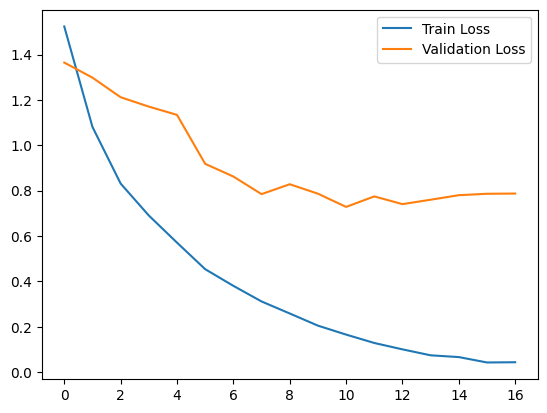

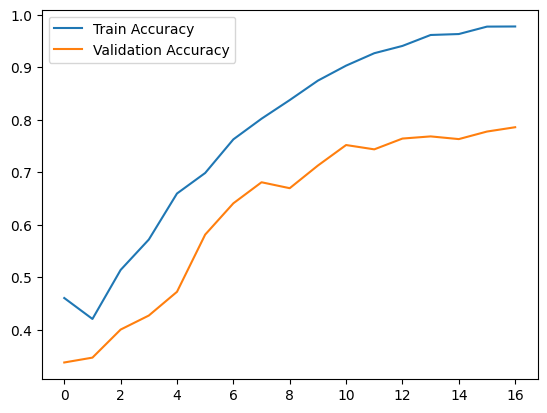

In [17]:
# 학습결과 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [18]:
# 평가
loss, accuracy = model.evaluate(test_seq)
print(f'loss: {loss:.4f}, accuracy: {accuracy:.4f}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - accuracy: 0.7445 - loss: 0.6156
loss: 0.6844, accuracy: 0.7449


In [19]:
# 모델 저장
model.save(f'ResNet50.loss-{loss:.2f}-accuracy-{accuracy:.2f}.h5')  # .h5 확장자 파일로 저장